# Introduction #

## Simulating a complex system ##

Suppose a non-stop, one-server shop opens daily at 9:00AM, and serves its customers using a first-in first-out approach: when a customer enters the shop, if there are no other customers it is served immediately, otherwise s/he places in line and waits that all previously entered customers are served. At 17:00PM, if there are no customers being served or waiting in line the server closes the shop. Otherwise s/he finishes to serve the clients not allowing new customers to wait in line, then the shop will be closed. Let's focus on the question "at what time the shop is closed?" Of course each day will possibily have a different closing time, thus we will be interested in considering a random variable $C$ whose specifications correspond to the closing time, and we would like to obtain its distribution. In order to do that, it is necessary to have more information about the arrival time of customers and the duration of their service. Let's start from the following hypotheses:

- the inter-arrival time between two customers who successively enter the shop follows a negative exponential distribution accounting for 15 total customers on the average in a fixed day, and
- the serving time of customers follows a Gaussian distribution whose mean and standard deviation are 20 and 4 minutes, respectively.

Let's try to model this problem analytically, denoting

- by $\Delta T_1, \dots \Delta T_i, \dots$ the random variable corresponding to inter-arrival times of customers who enter the shop in a given day, and by $T_i$ the random variable measuring the absolute arrival time of $i$-th customer,
- by $S_i$ the random variable related to the service time of $i$-th customer, and
- by $W_i$ the random variable stating the total time spent by $i$-th customer in the shop, thus amounting both for its service time and the time s/he possibily spent in line.

For each $i$, our hypotheses allow us to say that $S_i$ will be distributed according to a Gaussian law of mean and standard deviation respectively equal to 20 and 4, and that $\Delta T_i$ will follow a negative exponential distribution with parameter $\lambda = 15/480$ (there are 480 minutes between 9AM and 5PM, thus if on the average we have 15 customers in a day, the mean inter-arrival time will be 480/15 and the parameter of the distribution will be the inverse of the latter quantity).

Deriving the distribution of the closing time $C$ is a bit tricky. First of all, note that

$$
W_i = S_i + \max \{ 0, W_{i-1} - \Delta T_i \},
$$

because if the total time spent in the shop by the previous customer is less than the time needed in order for the next customer to arrive, then the latter will find an empty queue and thus he will stay only as long as his/her service time $S_i$ requires. Otherwise, its total time spent in the shop will also account for the time $W_{i-1} - \Delta T_i$ s/he waits in line. If we suppose to know that in a day there will be precisely $n$ customers, we are interested in the time the last arrived, thus the $n$-th one, leaves the system. This time is equal to

$$
\left( \sum_{i=1}^n \Delta T_i \right) + W_n.
$$

This result is obtained adding to the arrival time of last customer (the sum in brackets) its total time spent in the shop. Thus we have $C = \max \left\{480, \left( \sum_{i=1}^n \Delta T_i \right) + W_n \right\}$. Unfortunately, the number $n$ of customers is not fixed because arrival times are randomly drawn. Precisely, we will have to consider the random variable

$$
N = \max n \text{ such that } \sum_{i=1}^n \Delta T_i \leq 480,
$$

and substitute in to $n$ in the previous equation used in order to find $C$.

Now, even if we know the distribution of all ingredients (namely, $\Delta T_i$ and $S_i$), we are not able to exploit the previous modelization in order to find out an analytical form for the distribution of $C$. We can however consider this problem under a different point of view: if we suppose we can use a computer in order to simulate the process of randomly draw the above mentioned ingredients from their distribution, we can write the code that computes the formulas making up the formalization, run it, and obtain a plausible specification for $C$.

In order to have in place all the libraries needed to write this code, run it and analyze its outputs. We will rely on the following components:

- `matplotlib` in order to produce graphics (the magic beginning next cell allows such graphics to be produced directly within jupyter);
- the `scipy` package, allowing us to not re-implement the pseudorandom generators needed in order to start our simulations;
- the `numpy` package, which we will extensively use in order to produce and process arrays of numerical values;
- the `pandas` package, providing a powerful implementation of tabular data structures.
- some jupyter components which will enable us to render interactive simulations.

Don't be scared for the number of external components: we will need them throughout the chapter, and most of the times they are needed just to wrap-up our results in a nice graphical form.

In [4]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.xkcd(); # just for funny, XKCD-styled figures

from scipy import random

import numpy as np

import pandas as pd

from ipywidgets import widgets
from IPython.display import display, clear_output, HTML

Let's also parametrize our modelization:

In [5]:
START_TIME = 540      # minutes after midnight corresponding to 9AM
WORK_DURATION = 480   # number of minutes in a working day
MEAN_ARRIVAL = 15     # average number of customers per day
MEAN_SERV_TIME = 20   # average service time
STD_SERV_TIME = 4     # standard deviation of service times

Suppose now that the following two functions are able to predict the service time of a customer, as well as the time laps occurring between the arrival of two consecutive customers. Don't worry about how these estimates are computed, as we'll come to this later on.

In [6]:
def customer_serv_time(m, s):
    return int(random.normal(m, s))

def time_lag(n):
    return int(random.exponential(float(WORK_DURATION) / n))

Focus instead on the possibility to compose the two estimates in order to get a full description of the next customer entering our pharmacy. Here below you find a panel built using such software tools: clicking on the button you'll see the simulated values appearing in the text area below the button.

In [8]:
button_customer_data = widgets.Button(description='Simulate!')
text = widgets.Label(value='Click on the button above...')

def display_customer_data(b):
    next_arrival = time_lag(MEAN_ARRIVAL)
    next_serv = customer_serv_time(MEAN_SERV_TIME,
                                                  STD_SERV_TIME)
    text.value = 'Next customer will arrive in %d minutes, ' \
                 'its service will take %d minutes.' \
                 % (next_arrival, next_serv)

button_customer_data.on_click(display_customer_data)
display_customer_data(button_customer_data)
display(widgets.VBox([button_customer_data, text], ))

It will be fairly easy to use this functions as tools in order to simulate the workload for one day: starting from opening time, it will suffice to repeteadly store the service time and compute the arrival time as the sum between inter-arrival time and previous customer arrival time. The simulation will stop when the next customer arrival time occurs after 5PM and the function will return two arrays containing respectively time lags and service times.

In [9]:
def simulate_pharmacy():
    time = 0
    time_lags = []
    while time < WORK_DURATION:
        lag = time_lag(MEAN_ARRIVAL)
        time += lag
        time_lags.append(lag)
    del time_lags[-1]
    
    service_times = [customer_serv_time(MEAN_SERV_TIME,
                                        STD_SERV_TIME) 
                          for a in time_lags]
    return (np.array(time_lags), np.array(service_times))

The inter-arrival times will be generated as floating-point values, thus for sake of readability it is appropriate to set up a function converting each generated time into a human-readable time format.

In [10]:
def to_time(mins):
    return '{:02d}:{:02d}'.format(*divmod(START_TIME+mins, 60))

The panel below behaves exactly in this way, building a table which gathers all customer data for a possible workday each time the button is pressed.

In [12]:
button_simple_schedule = widgets.Button(description='Simulate my day!')

def compute_simple_schedule(b):
    inter_arrivals, services = simulate_pharmacy()
    arrivals = inter_arrivals.cumsum()
    day_schedule = pd.DataFrame(columns=['Arrival', 'Service time'])
    day_schedule['Arrival'] = [to_time(a) for a in arrivals]
    day_schedule['Service time'] = services
    clear_output()
    display(HTML(day_schedule.to_html(index=False)))

button_simple_schedule.on_click(compute_simple_schedule)
compute_simple_schedule(button_simple_schedule)

display(button_simple_schedule)

Arrival,Service time
09:15,26
09:16,21
09:33,26
10:09,19
12:04,23
12:24,22
12:25,15
12:27,18
13:09,15
13:18,27


Of course the number of rows in the table will change each time the table is generated, because the number of customers is not fixed. With slightly more complex functions it is also possible to record additional data about the customers, such as their total service time (accounting for the time possibly spent waiting in line), their exit time and the numer of customers already in line at each arrival.

In [13]:
def get_in_system_times(inter_arrivals, service_times):
    num_customers = len(inter_arrivals)
    ist = [0] * num_customers
    ist[0] = service_times[0]
    prev_service_time = service_times[0]
    
    for i in range(1, num_customers):
        curr_service_time = \
            max(0, prev_service_time - inter_arrivals[i]) \
            + service_times[i]
        ist[i] = curr_service_time
        prev_service_time = curr_service_time
    
    return np.array(ist)

def get_queue_lengths(inter_arrivals, service_times):
    in_system_times = get_in_system_times(inter_arrivals, service_times)
    arrivals = inter_arrivals.cumsum()
    exit_times = arrivals + in_system_times
    queue_lengths = [sum([1 if et > arrivals[i] else 0 
                     for et in exit_times[:i]]) for i in range(len(arrivals))]
    return np.array(queue_lengths)

Using these new functions it is possible to get a fancier table.

In [17]:
button_full_schedule = widgets.Button(description='Simulate my day!')

def get_full_schedule(b):
    inter_arrivals, services = simulate_pharmacy()
    arrivals = inter_arrivals.cumsum()
    exits = arrivals + get_in_system_times(inter_arrivals, services)
    lengths = get_queue_lengths(inter_arrivals, services)
    
    day_schedule = pd.DataFrame(columns=['Arrival', 'Queue length', 'Service time', 'Exit'])
    day_schedule['Arrival'] = [to_time(a) for a in arrivals]
    day_schedule['Queue length'] = get_queue_lengths(inter_arrivals, services)
    day_schedule['Exit'] = [to_time(e) for e in exits]
    day_schedule['Service time'] = services
    clear_output()
    display(HTML(day_schedule.to_html(index=False)))

button_full_schedule.on_click(get_full_schedule)
get_full_schedule(button_full_schedule)

display(button_full_schedule)

Arrival,Queue length,Service time,Exit
09:18,0,21,09:39
09:53,0,20,10:13
10:55,0,18,11:13
11:13,0,22,11:35
11:16,1,20,11:55
12:19,0,19,12:38
12:43,0,16,12:59
13:01,0,19,13:20
13:30,0,19,13:49
13:55,0,20,14:15


The workday simulation can also be rendered visually, instead than in tabular form. For instance, the following panel will generate a picture containing an horizontal bar for each customer, spanning the total time s/he spends in the farmacy (showing in-line and service times in light and dark blue, respectively). The last bar will thus determine the actual closing time.

<IPython.core.display.Javascript object>


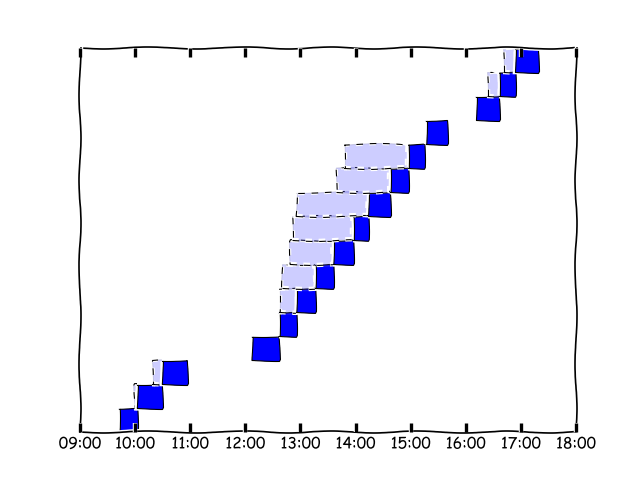

In [18]:
button_day_graph = widgets.Button(description='Simulate my day!')

fig, ax = plt.subplots()
    
def update_day_graph(b):
    inter_arrivals, services = simulate_pharmacy()
    arrivals = inter_arrivals.cumsum()
    exits = arrivals + get_in_system_times(inter_arrivals, services)
    ax.clear()
    
    y = 0
    for a, s, e in zip(arrivals, exits-services, exits):

        ax.add_patch(patches.Rectangle((a, y), s-a, 20, alpha=0.1))
        ax.add_patch(patches.Rectangle((a, y), s-a, 20, fill=None, linestyle='dashed', edgecolor='black'))
        ax.add_patch(patches.Rectangle((s, y), e-s, 20))
        y += 20

    plt.xlim(0, max(exits))
    plt.ylim((0, y))

    xlocs = np.arange(0, max(exits)+60, 60)
    plt.xticks(xlocs, map(to_time, map(int, xlocs)))
    ax.yaxis.set_ticks([])

button_day_graph.on_click(update_day_graph)
display(button_day_graph)
update_day_graph(button_day_graph)

We have thus obtained the result we wanted to get. In order to further process this information, the following function simulates a one-day workload and returns the corresponding closing time.

In [21]:
def closing_time(inter_arrivals, service_times):
    in_system_times = get_in_system_times(inter_arrivals, service_times)
    arrivals = inter_arrivals.cumsum()
    last_exit = (arrivals + in_system_times)[-1]
    return max(WORK_DURATION, last_exit)

We can use this function exactly as we did for instance with `customer_serv_time`, that is as a (higher level) tool simulating the closing time for a generic day:

In [22]:
button_exit_time = widgets.Button(description='Simulate my day!')
text = widgets.Label(value='Click on the button above...')

def get_exit_time(b):
    inter_arrivals, services = simulate_pharmacy()
    ct = closing_time(inter_arrivals, services)
    text.value = 'You\'ll go home at {}.'.format(to_time(ct))

button_exit_time.on_click(get_exit_time)
get_exit_time(button_exit_time)

display(widgets.HBox([button_exit_time, text]))

Although the above answer isn't particularly interesting per se, we can think of it as an observation of the random variable $C$ describing closing time. Grouping together several such observations we are able to build a sample of this random variable and compute meaningful statistics on it. For instance, the following panel simulates 100 working days and generates the corresponding histogram for closing times.

<IPython.core.display.Javascript object>


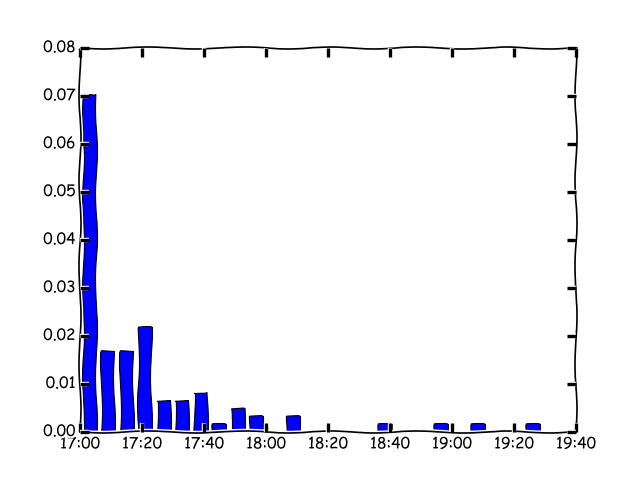

In [23]:
button_exit_distribution = widgets.Button(description='Simulate my day!')

fig, ax = plt.subplots()

def get_exit_distribution(b):
    num_simulations = 100
    closing_times = np.array([closing_time(*simulate_pharmacy())
                              for i in range(num_simulations)])

    hist, bins = np.histogram(closing_times, bins=25, density=True)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.clear()
    ax.bar(center, hist, align='center', width=width)
    xlocs, xlabs = plt.xticks()
    plt.xticks(xlocs, map(to_time, map(int, xlocs)))


button_exit_distribution.on_click(get_exit_distribution)
get_exit_distribution(button_exit_distribution)

display(button_exit_distribution)

You can play with this panel in order to get an idea of the distribution properties: most of the probability mass is concentrated on 5PM, although a non-negligible fraction of times the server will have to stay up to half an hour after the official closing time. Moreover, in some cases the shop will close fairly later.

Using this technique it is possible to pose queries about any property which can be simulated. For instance, the following panel estimates the distribution of the total time each customer spends in the pharmacy, accounting for time spent both waiting in line and getting his service.

<IPython.core.display.Javascript object>


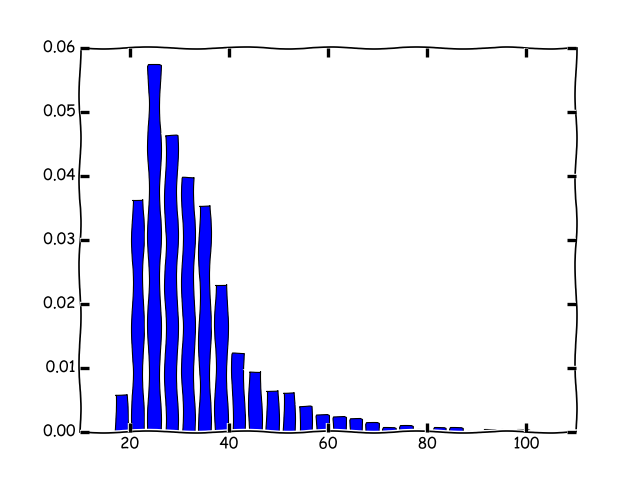

In [25]:
button_in_sys = widgets.Button(description='Simulate my day!')

fig, ax = plt.subplots()

def get_in_sys_times(b):
    num_simulations = 1000
    in_sys_times = np.array([np.array(get_in_system_times(*simulate_pharmacy())).mean()
                             for i in range(num_simulations)])
    
    hist, bins = np.histogram(in_sys_times, bins=25, density=True)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.clear()
    ax.bar(center, hist, align='center', width=width)
    xlocs, xlabs = plt.xticks()

button_in_sys.on_click(get_in_sys_times)
get_in_sys_times(button_in_sys)

display(button_in_sys)

Similarly, we can study the queue length distribution at any customer arrival.

<IPython.core.display.Javascript object>


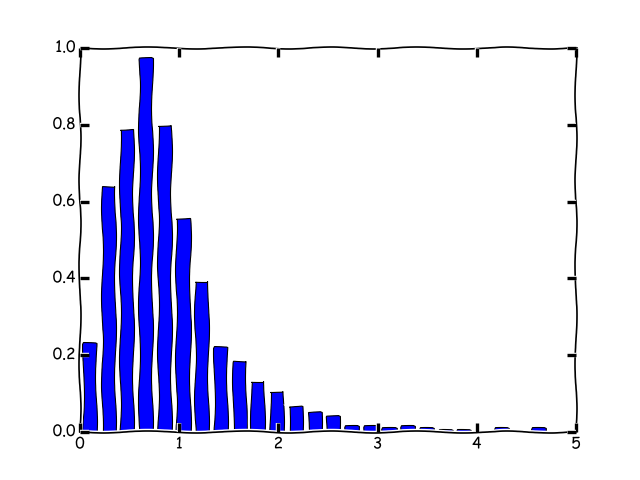

In [26]:
button_queue_length = widgets.Button(description='Simulate my day!')

fig, ax = plt.subplots()

def get_queue_length(b):
    num_simulations = 1000
    queue_lengths = np.array([np.array(get_queue_lengths(*simulate_pharmacy())).mean()
                              for i in range(num_simulations)])
    
    hist, bins = np.histogram(queue_lengths, bins=25, density=True)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.clear()
    ax.bar(center, hist, align='center', width=width)

button_queue_length.on_click(get_queue_length)
get_queue_length(button_queue_length)
display(button_queue_length)

It is also possible to study events which can either be satisfied or unsatisfied in a simulation run: it will suffice to collect the values 1 and 0 when the event is satisfied or not, respectively. For instance, the following panel estimates the fraction of time the shop is closed after 5PM.

<IPython.core.display.Javascript object>


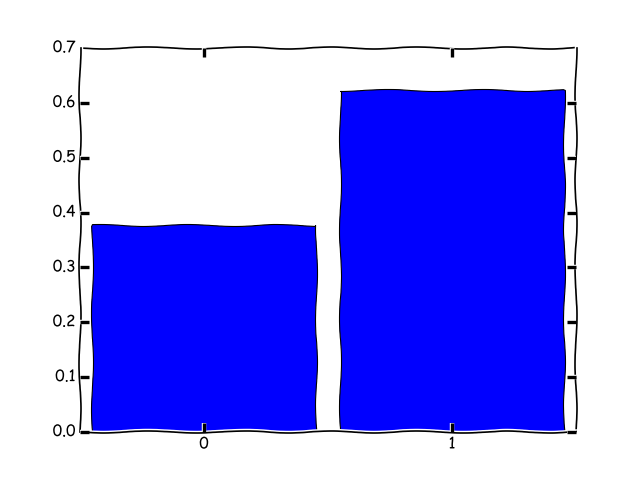

In [27]:
def extra_time_fraction(inter_arrivals, service_times):
    ct = closing_time(*simulate_pharmacy())
    return 1 if ct > WORK_DURATION else 0

button_fraction = widgets.Button(description='Simulate my day!')

fig, ax = plt.subplots()

def get_extra_time_frac(b):
    num_simulations = 1000
    extra_times = np.array([extra_time_fraction(*simulate_pharmacy())
                            for i in range(num_simulations)])
    
    hist, bins = np.histogram(extra_times, weights=[1.0/num_simulations] * num_simulations, bins=2)
    width = .9
    center = (0, 1)
    
    ax.clear()
    ax.bar(center, hist, align='center', width=width)
    plt.ylim((0, 0.7))
    plt.xticks((0, 1), (0, 1))

button_fraction.on_click(get_extra_time_frac)
get_extra_time_frac(button_fraction)
display(button_fraction)

# The Monty Hall dilemma #

_Let's make a deal_ was a popular TV game show broadcast on NBC between 1963 and 1986. The game consisted in several deals proposed by the host, Monty Hall, to the game traders. A deal consisted in giving traders the opportunity to choose between different possibilities, each associated to prizes of variable value, be it high, low or even undesirable. This game has inspired a famous probability problem, named _Monty Hall dilemma_ after the show host. The problem can be stated in terms of a trader participating to the show having to choose one among three doors, knowing that behind one of them there is a car, whereas behind the remaining ones there are goats. After he has chosen a door, the show host opens one of the unchosen ones, revealing a goat, and offers the dealer the possibility to change its initial choice. If the car is assigned uniformly at random to the three doors, does the door switch increases the probability that the dealer will find the car?

![A picture of Monty Hall](https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Monty_hall_abc_tv.JPG/184px-Monty_hall_abc_tv.JPG)
<center>**A picture of Monty Hall in the 1970s** [source: [Wikimedia](https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Monty_hall_abc_tv.JPG/184px-Monty_hall_abc_tv.JPG)]</center>

The following panel allows you to simulate such a game. Press the button labeled _Choose me!_ under the door you chose: you will see that one of the remaining doors reveals that it contains a goat, and its button gets disabled, while the other ones pertaining to the chosen and remaining door relabel themselves as _Keep_ and _Change_, respectively. Now press the former button if you want to confirm your initial choice, or press the latter if you want to switch: what is hidden behind each door will be revealed so that you will be able to verify if you have won. At any time, hit _Reset_ if you want to start over.

In [28]:
doors = [widgets.Button() for i in range(1, 4)]

button_reset = widgets.Button(description='Reset')
prizes = [('Goat', 'Goat', 'Car')[i] for i in np.argsort(random.random(3))]

def reset(button):
    global prizes
    prizes = [('Goat', 'Goat', 'Car')[i] for i in np.argsort(random.random(3))]
    for i in range(3):
        doors[i].description = 'Door #{}'.format(i+1)
        doors[i].button_style = ''
        doors[i].disabled = False
        
button_reset.on_click(reset)
reset(button_reset)

def choose(i):
    def choice_handler(chosen):
        if chosen.description in ('Keep', 'Change'):
            for j in range(3):
                if doors[j].description == 'Keep':
                    doors[j].button_style = 'success' if prizes[j] == 'Car' else 'danger'
                if doors[j].description == 'Change':
                    doors[j].button_style = ''

                doors[j].description = prizes[j]
        else:
            chosen.button_style = 'primary'
            chosen.description = 'Keep'
            revealed = random.choice([j for j in range(3) if prizes[j]!='Car' and j!=i])
            doors[revealed].description = prizes[revealed]
            doors[revealed].disabled = True
            remaining = [j for j in range(3) if j!=i and j!=revealed][0]
            doors[remaining].description = 'Change'
            doors[remaining].button_style = 'warning'        
    return choice_handler

for i in range(3):
    doors[i].on_click(choose(i))

display(widgets.HBox((widgets.VBox(doors), button_reset)))

The problem underneath this game was discussed in two numbers of _American Statistician_ in 1975, although it received a broader attention in 1990 when it was posed as a question in the _Ask Marylin_ column of _Parade Magazine_. The columnist, Marylin Vos Savant, advocated that the best strategy was that of changing the initially chosen door, because in this case the odds in favour of winning doubled. This answer provoked the reaction of several readers, including mathematicians, who disagreed with the columnist. Actually Mrs. Vos Savant was right, because if the winning door is chosen uniformly at random, when the game begins there is a 1/3 probability that any door is the correct one; thus the probability that the car is behind the chosen door is 1/3 and the probability that the prize is behind one of the remaining doors is 2/3. If we call A the chosen door, when the host reveals a goat under door B, the dealer has two key informations:
- the probability that the car is behind B or C is 2/3, and
- the car is not behind B.
This allows us to deduce that the probability that the winning door is C is 2/3, which doubles the odds in favour of our initial choice of A.

Another proof is sketched in the following table, where for a given arrangment of car and goats (which is irrelevant for the proof construction), all the three possibilities corresponding to the initial choice are listed as a row in the table, where the chosen prize is underlined and the column _Change_ has entries _Win_ or _Loose_, respectively, when switching the chosen door leads to winning or losing the car. Idem for the _Keep_ column, whose entry says whether or not the strategy of keeping the initially chosen door is a winning one.

| Door1   | Door2    | Door3    | Change  | Keep  |
|---------|----------|----------|---------|-------|
| **Car** | Goat     | Goat     | Loose   | Win   |
| Car     | **Goat** | Goat     | Win     | Loose |
| Car     | Goat     | **Goat** | Win     | Loose |

Another proof makes use of the Bayes' theorem involving conditional probabilities. In its simplest form, this theorem states that if $A$ and $B$ are events and $\mathrm P(A) \neq 0$

$$
\mathrm P(B | A) = \frac{\mathrm P(A | B)\mathrm P(B)}{\mathrm P(A)}.
$$

Assume that doors are identified with numbers 1, 2, and 3, and denote by $c$, $o$, and $r$ the numbers corresponding to the chosen, opened, and remaining doors, respectively. Moreover, let $d: \{1, 2, 3\} \mapsto \{ \mathrm{C}, \mathrm{G} \}$ be the function associating each door with the corresponding prize (with $\mathrm{C}$ and $\mathrm{G}$ ovbiously denoting "Car" and "Goat").

By our initial hypothesis that prizes are assigned uniformly at random to doors we know that

$$
\mathrm P(d(c) = \mathrm{C}) = \mathrm P(d(o) = \mathrm{C}) = \mathrm P(d(r) = \mathrm{C}) = \frac{1}{3},
$$

and focusing on the event $O = \text{the door o is opened}$, by the total probability theorem we can get that

$$
\mathrm P(O) =
        \mathrm P(O | d(c) = \mathrm{C}) \mathrm P(d(c) = \mathrm{C}) +
        \mathrm P(O | d(r) = \mathrm{C}) \mathrm P(d(r) = \mathrm{C}) +
        \mathrm P(O | d(o) = \mathrm{C}) \mathrm P(d(o) = \mathrm{C})
$$

Now:
- $\mathrm P(O | d(o) = \mathrm{C})$ is obviously 0;
- $\mathrm P(O | d(r) = \mathrm{C})$ is 1 because in this case the trader has chosen a wong door, thus there is only one left to open;
- $\mathrm P(O | d(c) = \mathrm{C}) = 1/2$ because Monty Hall can open any of the remaining doors.

Summing up,

$$
\mathrm P(O) = \frac{1}{2} \frac{1}{3} + 1 \frac{1}{3} = \frac{1}{2}.
$$

Finally, according to the Bayes' theorem we can compute

$$
\mathrm P(d(c) = \mathrm{C} | O) =
\frac{\mathrm P(O | d(c) = \mathrm{C}) \mathrm P(d(c) = \mathrm{C})}{\mathrm P(O)} =
\frac{\frac{1}{2} \frac{1}{3}}{\frac{1}{2}} =
\frac{1}{3},
$$

and by obvious probability properties $\mathrm P(d(r) = \mathrm{C}) | O) = 1 - \mathrm P(d(c) = \mathrm{C} | O) = \frac{2}{3}$. Thus the switching door strategy actually doubles the odds of winning.

Even one of the greatest mathematicians of the nineteenth century, Paul Erdős, was't convinced of two analytical solutions to the Monty Hall dilemma proposed by his friend and colleague Andrew Vázsonyi, so the latter tried a third approach based on simulation: he wrote on his PC a program encoding the following algorithm, exploiting a pseudorandom generator in order to set up the prizes behind each door and to decide the initial choice, then verifying whether or not the door switch strategy led to winning the car:

```
procedure change(): boolean
  doors = pseudo-random-permutation({"Car", "Goat", "Goat"})
  choice = random(1, 3)
  return doors[choice] != "Car"
```

That program was run 100,000 times, roughly two thirds of which it gave rise to a winning situation. Let's encode this algorithm, and its counterpart checking the door keep strategy:

In [30]:
def monty_hall_keep():
    prizes = [('Goat', 'Goat', 'Car')[i]
              for i in np.argsort(random.random(3))]
    choice = random.choice(range(3))
    return 1. if prizes[choice]=='Car' else 0.

def monty_hall_change():
    prizes = [('Goat', 'Goat', 'Car')[i]
              for i in np.argsort(random.random(3))]
    choice = random.choice(range(3))
    return 0. if prizes[choice]=='Car' else 1.

The following panel repeats the simulation of Andrew Vazsonyi for both strategies in the Monty Hall dilemma: the first button simulates 500 deals, each tackled through the strategy of keeping the initially chosen door and shows the fraction of deals ended with a victory, while the second ones performs a similar simulation relying on the strategy based on door switch.

In [31]:
keep_button = widgets.Button(description='Keep strategy')
keep_label = widgets.Label()

def estimate_keep(button):
    win_prob = np.mean([monty_hall_keep() for i in range(500)])
    keep_label.value = 'Estimated win probability: {}'.format(win_prob)

estimate_keep(keep_button)
keep_button.on_click(estimate_keep)

change_button = widgets.Button(description='Change strategy')
change_label = widgets.Label()

def estimate_change(button):
    win_prob = np.mean([monty_hall_change() for i in range(500)])
    change_label.value = 'Estimated win probability: {}'.format(win_prob)

estimate_change(change_button)
change_button.on_click(estimate_change)

display(widgets.VBox((widgets.HBox((keep_button, keep_label)),
                      widgets.HBox((change_button, change_label)))))

It is easy to convince oneself that the results oscillate around 1/3 and 2/3. This particular kind of simulation belongs to a broader category known as _Monte Carlo methods_, which will be studied later on.

## Estimate probabilities in the Risk game ##

Risk is a strategy board game in which players are assigned a set of territories in the World and several armies, and goals to be achieved. There are variants of these rules depending on specific editions of the game. In all cases, at each game turn one player can decide to attack the territory of another player, and the attack result is decided after one or more dice toss. Precisely, the attacker decides whether s/he wants to use one, two, or three armies to support the attack. Its antagonist can in turn decide how many armies he wants to base his defense upon, although in the original game edition s/he cannot rely on more than two armies. Both players toss as many dice as armies they decided to use, and the highest obtained points are compared: the player with the best result keeps his/her army, and the other player should remove his army from the game. The process is possibly repeated for the second highest dice points.

The following panel simulates the attack of three armies when the attacked player uses two armies to defend his/herself: clicking on the _Play_ button simulates all five dice tosses, sorts them and decides whether or not the attacked player can keep at least one of his/her armies. 

In [38]:
def dice_throw(n):
    return random.choice(range(1, 7), n)

play_button = widgets.Button(description='Play')
attack_label = widgets.Label()
defense_label = widgets.Label()
result_label = widgets.Label()

def simulate_attack():
    attack = dice_throw(3)
    defense = dice_throw(2)

    attack.sort()
    defense.sort()
    
    resists = attack[-1] < defense[-1] and attack[-2] < defense[-2]
    
    return (attack, defense, resists)

def match(button):
    attack, defense, resists = simulate_attack()
    
    attack_label.value = 'Attack: {}'.format(' '.join(map(str, attack)))
    defense_label.value = 'Attack: {}'.format(' '.join(map(str, defense)))

    result_label.value = 'resists' if resists else 'doesn\'t resist'

match(play_button)
play_button.on_click(match)
display(widgets.HBox([play_button,
                      widgets.VBox([attack_label, defense_label]),
                      result_label]))

We can use a basic simulation technique, repeating this process several times and estimating the probability of resisting such an attack with the frequency of times the simulation does not end up with a full victory of the attacker.

In [40]:
risk_button = widgets.Button(description='Estimate')
risk_label = widgets.Label()

def estimate_resist(button):
    resist_prob = np.mean([simulate_attack()[2] * 1 for i in range(1000)])
    risk_label.value = 'Estimated resist probability: {}'.format(resist_prob)

estimate_resist(risk_button)
risk_button.on_click(estimate_resist)

display(widgets.HBox((risk_button, risk_label)))                    

## The italian «Lotto» ##

The term «Lotto» designates a particular Italian lottery (although similar chance games exists for instance in France and Switzerland) consisting in betting on configurations of five numbers uniformly drawn between 1 and 90. The simplest bet consists in choosing one number, and winning if that number is drawn, regardless of its position in the five extractions. Gamblers unexperienced in probability often rely on some sort of _memory_ of the game, claiming that since all numbers have the same probability to be drawn, there is a high likelyhood that a number not being drawn since several game rounds (a so-called «numero ritardatario», an Italian term roughly equivalent to «latecomer number») will appear in the next draw.

Of course the independece between two different draws directly implies that the probability of a number being extracted is constant, but when this kind of argumentation cannot breaks through the belief of such gamblers, maybe an alternative approach based on simulation could help. Let's simplify the context, assuming that there is only one number to be drawn uniformly between 1 and 90, repeatedly simulating such extraction, and take note of the frequency with which numbers are drawn. Before each turn, we also simulate to bet on the number having the smaller frequency in the recorded history of past draws (chosing randomly if there are several numbers corresponding to this frequency). The following panel performs such a simulation, allowing to perform a hundred new draws and showing how the winning frequency evolves with time. This graph, shown in blue, is compared with the constant graph (in red) corresponding to the constant probability of 1/90 to win if bets are placed uniformly at random. At any moment, pressing the _Reset_ button will clear the draw history and restart the process.

<IPython.core.display.Javascript object>


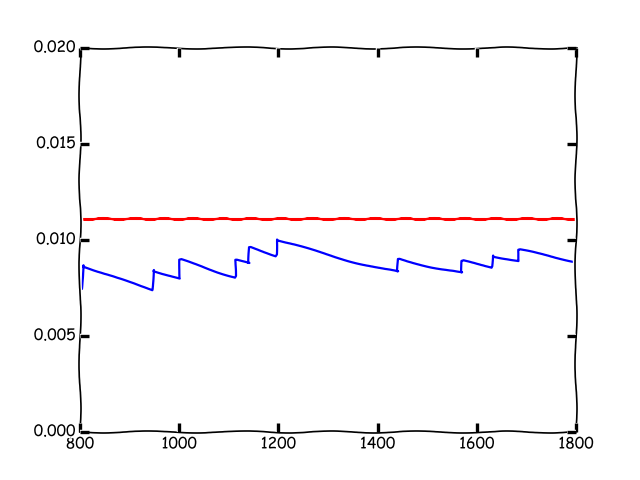

In [32]:
start_button = widgets.Button(description='Add 100 draws')
reset_button = widgets.Button(description='Reset')

fig, ax = plt.subplots()

def add_simulation(button):
    global results, num_hits, num_draws, current_draw, frequencies
    
    for d in range(100):
        if len(num_draws) == 1000:
            del num_draws[0]
        num_draws.append(current_draw)
        
        least_frequent = np.argmin(results)
        drawn = random.choice(range(90))
        results[drawn] += 1
        if drawn == least_frequent:
            num_hits += 1
        current_draw +=1
        if len(frequencies) == 1000:
            del frequencies[0]
        frequencies.append(float(num_hits)/current_draw)
    ax.clear()
    ax.plot(num_draws, frequencies)
    ax.plot(num_draws, [1./90]*len(num_draws), c='r')
    plt.ylim((0, 0.02))

def reset(button):
    global results, num_hits, num_draws, current_draw, frequencies
    
    results = [0] * 90
    num_hits = 0
    num_draws = []
    current_draw = 1
    frequencies = []
    add_simulation(button)

reset_button.on_click(reset)
reset(reset_button)

start_button.on_click(add_simulation)
add_simulation(start_button)

display(widgets.HBox((start_button, reset_button)))

Playing with this simulation will show how the «latecomers» strategy actually doesn't significantly change the simple one of chosing at random.

## The Student's t distribution ##

At the beginning of '900 William Gosset was employed at the Guinness brewery, and he was in charge of applying statistical methods in order to assess the quality of raw materials such as barley. In particular, in a paper appeared in 1908 in the _Biometrika_ journal, he describes a distribution involved in the inference of the mean of normal distributions in the specific case of small-sized samples. This distribution is named after the pseudonym _Student_ used by Gosset to pubish this paper (the motivations behind this fact are unclear, although it is often said that Guinness did not want to disclose to its competitors the methodologies behing their quality assessment of raw materials).

![A picture of William Gosset](https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/William_Sealy_Gosset.jpg/186px-William_Sealy_Gosset.jpg)
<center>**A picture of William Gosset in 1908** [source: [Wikimedia](https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/William_Sealy_Gosset.jpg/186px-William_Sealy_Gosset.jpg)]</center>

The Student's t distribution was defined so as to safisfy several properties. One of these required that the ratio between a standard gaussian random variable and the square root of a chi-squared variable divided by the number of its degrees of freedom should follow a Student's t distribution. More formally, if $Z$ is a standard Gaussian random variable and $U$ is a chi-squared random variable with $k$ degrees of freedom, $Z / \sqrt{U/k}$ will follow a Student's t distribution with $k$ degrees of freedom. In order to empirically check such property, Gosset started from a 3,000 sized sample of measurements of criminal fingers, knowing that this sample approximately followed a Gaussian distribution. He considered groups of four standardized sample elements, getting 750 subsamples, and for each subsample he computed

- the sample mean and standardized it (multiplying it times the square root of the subsample size, that is 2), getting a standard Gaussian specification, and
- the sum of square errors from the sample mean, thus leading to specification of a chi-squared distribution with three degrees of freedom.

We can therefore simulate this experiment starting from a set of values drawn from a standard Gaussian distribution. Referring to the notation previously introduced, we will divide our original sample in subsamples of $n$ elements. On the one hand, we will multiply the average of each subsample times $\sqrt{n}$ to standardize the result, obtaining specifications of $Z$. On the other one, we will compute the mean square error, obtaining a specification of $U$ with $n-1$ degrees of freedom, and divide the results by this number of degrees. Finally, we will compute the division of the two obtained values.

We can easily replicate the original experiment of Gossett. The following cell, besides generating the data to be used to plot the theorical CDF of the Student's t distribution, declares two functions:

- `t_specification`, taking as input a subsample and computing the corresponding value for the Student's t specification, and
- `ecdf`, computing the coordinates of all significant points of the empirical CDF for the data passed as input.

In [35]:
import math
from scipy.stats import t

df = 4
num_data = 3000
x_cdf = np.linspace(t.ppf(0.01, df), t.ppf(0.99, df), 100)
y_cdf = t.cdf(x_cdf, df)

def t_specification(d):
    n = len(d)
    xm = d.mean()
    chi = sum((d - xm)**2)
    return xm * math.sqrt(n) / math.sqrt(chi / (n-1))

def ecdf(data):
    sorted = np.sort(data)
    yvals = np.arange(len(sorted))/float(len(sorted))
    return((sorted, yvals))

Using these functions we can recreate the experiment of Gossett: the following panel draws 3000 gaussian values and applies them the subsampling technique, obtaining 750 numbers. Afterwards, their empirical CDF is shown, superimposing its graph with those of the theorical CDF of the Student's t distribution. Clicking on the _Generate_ button will repeat the process: each time the empirical CDF will result as a good approximation of the theorical one.  

<IPython.core.display.Javascript object>


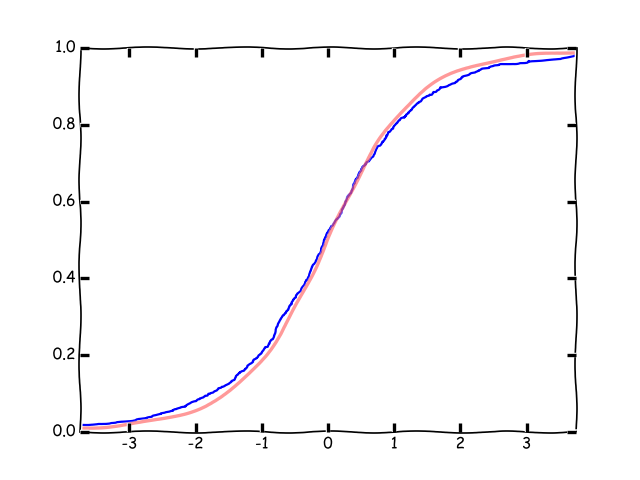

In [36]:
ecdf_button = widgets.Button(description='Generate')

fig, ax = plt.subplots()

def generate_ecdf(button):
    data = np.array([random.normal(0, 1) for i in range(num_data)])
    data.resize((num_data/deg, deg))
    t_data = map(t_specification, data)
    x_ecdf, y_ecdf = ecdf(t_data)
    ax.clear()
    ax.plot(x_ecdf, y_ecdf)
    ax.plot(x_cdf, y_cdf, 'r-', lw=3, alpha=0.4)
    plt.xlim(x_cdf[0], x_cdf[-1])

ecdf_button.on_click(generate_ecdf)
generate_ecdf(ecdf_button)

display(ecdf_button)

We can also repeat this experiment with different parametrizations for the number of original data and the subsample size.

<IPython.core.display.Javascript object>


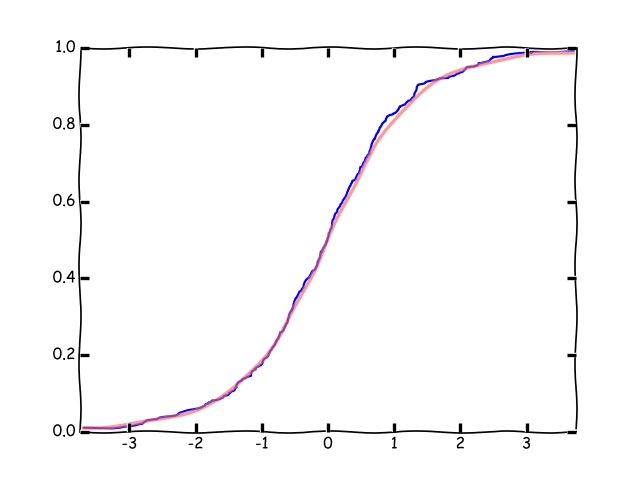

In [37]:
from ipywidgets import interact

def student_t_simulation(num_data, deg):
    fig, ax = plt.subplots()
    data = np.array([random.normal(0, 1) for i in range(num_data)])
    data.resize((num_data/deg, deg))
    t_data = map(t_specification, data)
    x_ecdf, y_ecdf = ecdf(t_data)
    ax.clear()
    ax.plot(x_ecdf, y_ecdf)
    ax.plot(x_cdf, y_cdf, 'r-', lw=3, alpha=0.4)
    plt.xlim(x_cdf[0], x_cdf[-1])

interact(student_t_simulation, num_data=(100, 5000, 100), deg=(2, 10, 1))

## Bibliographic references ##

The shop example is adapted from the motivating example opening [Ross, 1984]. A deeper description of the Monty Hall problem can be found in [Snider et al., 2010]

[Ross, 1984] Sheldon Ross, Simulation, 4th edition.
[Snider et al., 2010] Irvin Snider, Assurant Health, and Milwaukee WI, Monty Hall, Paul Erdˆs, and Monte Carlo, 2010, available online at http://www.mwsug.org/proceedings/2010/stats/MWSUG-2010-87.pdf